# Projet Leyenda - Livrable 1 - Classification binaire

## Sommaire

* [1. Introduction](#chapiter1)
    * [1.1. Rappel du besoin](#section_1_1)
    * [1.2. Expression du besoin](#section_1_2)
    * [1.3. Contraintes](#section_1_3)
* [2. Réalisation du modèle de classification](#chapter2)
    * [2.1. Import des librairies Python](#section_2_1) 
* [3. Analyse des résultats](#chapiter3)
* [4. Amélioration du modèle](#chapiter4)
* [5. Conclusion](#chapitre5)

## 1. Introduction <a class="anchor" id="chapter1"></a>

### 1.1 Rappel du besoin <a class="anchor" id="section_1_1"></a>

<div style="text-align: justify">Dans le cadre de ce projet l'entreprise TouNum spécialisée dans la numérisation de documents souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possédant une grande quantité de données à numériser au format papier. Dans le but de rester compétitif dans ce secteur d’activité l’entreprise décide d’innover et proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science de CESI ont été contactés.
<p>

L’objectif de cette première partie est d’automatiser la sélection des photos pour l’annotation. Pour ce faire, nous nous basons sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos dans le dataset de départ.<div>

### 1.2 Expression du besoin <a class="anchor" id="section_1_2"></a>

<div style="text-align: justify">Afin d’apporter une réponse adaptée à la problématique énoncée dans l’introduction de ce notebook. Il nous apparaît intéressant d’analyser le besoin de l’utilisateur final. Cette démarche a pour but de 
donner un point de vue global des attendus aux quelles la solution doit répondre. Ce qui nous 
donnera une ligne directrice à suivre tout au long de ce notebook. Afin, de donner un aperçu plus clair sur la marche à suivre pour répondre au besoin exprimé nous pouvons nous aider du diagramme bête à corne ci dessous.</div>

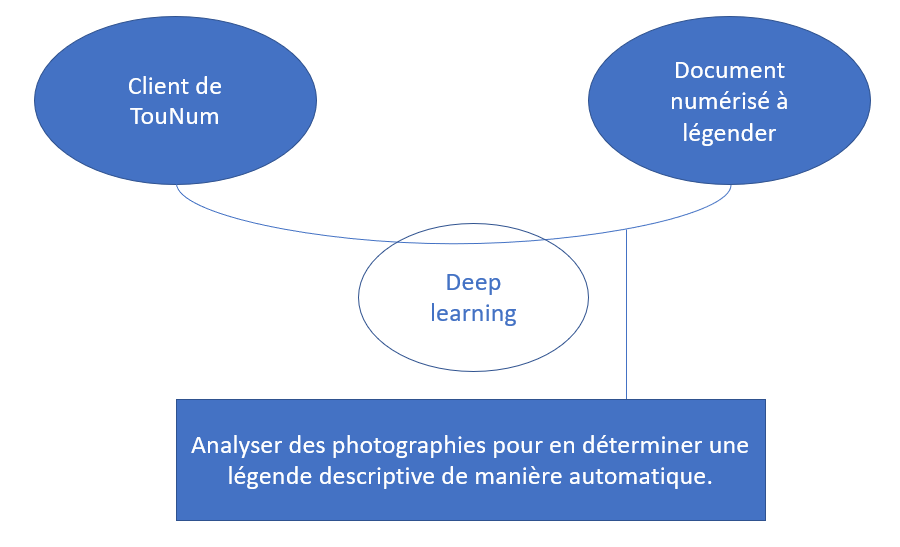
<center><em>Diagrame Bete à corne</em></center>

### 1.3 Contraintes <a class="anchor" id="section_1_3"></a>

<div style="text-align: justify">Cette première partie comporte plusieurs contraintes liées à la vision par ordinateur. En effet, nous devons être en capacité de déterminer si les images sont des photos sans tenir compte de l’orientation, de la luminosité, ou la  variation d’échelle de celles-ci. De plus, nous devrons extraire les features qui nous permettrons de distinguer les différences entre les types d’images qui composent le dataset.</div>  

## 2. Réalisation du modèle de classification <a class="anchor" id="chapter2"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import pathlib

data_dir = pathlib.Path("Class")

In [4]:
image_h = 180
image_w = 180
batch_s = 32

In [5]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  label_mode = "binary"
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  label_mode = "binary"
)

Found 41405 files belonging to 2 classes.
Using 33124 files for training.
Found 41405 files belonging to 2 classes.
Using 8281 files for validation.


In [6]:
class_names = train_set.class_names
print(class_names)

['Autre', 'Photo']


In [7]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 1)


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

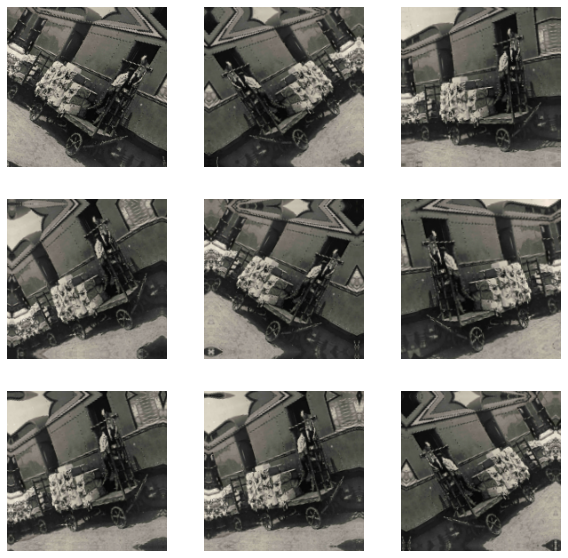

In [9]:
#Fonction s'occupant de la data augmentation, aujoutant au dataset d'entrainement des images légèrements modifiées par leur orientation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(image_h, 
                                                              image_w,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Rajoutez ensuite l'augmentation des données à votre CNN et vérifiez les courbes obtenues après entrainement et évaluation du modèle.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

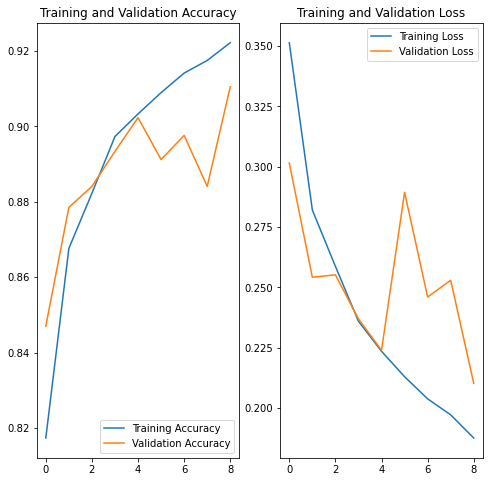

In [10]:
#def my_init(shape, dtype=None):     return K.random_normal(shape, dtype=tf.int32)

# Le modèle
complete_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  #layers.Dense(64, kernel_initializer=my_init),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])
# Compilation du modèle
complete_model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
# Résumé du modèle
complete_model.summary()

# Enrainement du modèle
epochs = 9
with tf.device('/device:GPU:0'):
  history = complete_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    #steps_per_epoch=4,
  )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

C:\Users\jbcst\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 9/19


C:\Users\jbcst\anaconda3\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


1036/1036 [==============================] - 91s 87ms/step - loss: 0.1679 - accuracy: 0.9313 - val_loss: 0.1850 - val_accuracy: 0.9230
Epoch 10/19
1036/1036 [==============================] - 97s 94ms/step - loss: 0.1636 - accuracy: 0.9336 - val_loss: 0.1896 - val_accuracy: 0.9217
Epoch 11/19
1036/1036 [==============================] - 101s 98ms/step - loss: 0.1579 - accuracy: 0.9335 - val_loss: 0.1892 - val_accuracy: 0.9221
Epoch 12/19
1036/1036 [==============================] - 82s 79ms/step - loss: 0.1590 - accuracy: 0.9350 - val_loss: 0.1879 - val_accuracy: 0.9225
Epoch 13/19
1036/1036 [==============================] - 90s 87ms/step - loss: 0.1560 - accuracy: 0.9355 - val_loss: 0.1915 - val_accuracy: 0.9220
Epoch 14/19
1036/1036 [==============================] - 97s 93ms/step - loss: 0.1543 - accuracy: 0.9357 - val_loss: 0.1902 - val_accuracy: 0.9220
Epoch 15/19
1036/1036 [==============================] - 98s 94ms/step - loss: 0.1537 - accuracy: 0.9367 - val_loss: 0.1892 - val

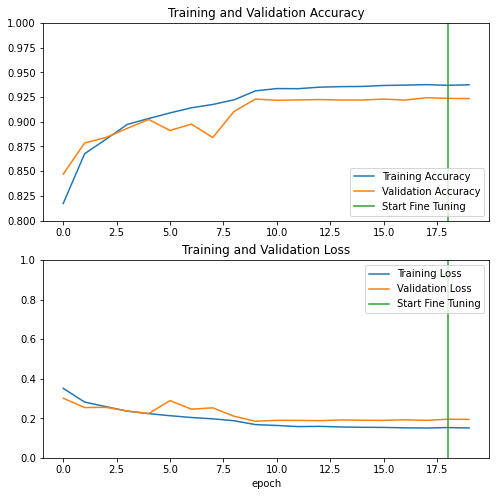

In [11]:
complete_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001/10),
              metrics=['accuracy'])
#model.summary()
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

history_fine = complete_model.fit(train_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_set)
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([total_epochs-1,total_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([total_epochs-1,total_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Accuracy, ROC Curve, and AUC

Let's evaluate the accuracy of our model:

In [12]:
from sklearn.metrics import classification_report

predictions = complete_model.predict(test_set)
predicted_categories = [1 * (x[0]>=0.5) for x in predictions]
true_categories = tf.concat([y for x, y in test_set], axis=0)


print(classification_report(true_categories, predicted_categories, target_names = class_names ))

              precision    recall  f1-score   support

       Autre       0.97      0.93      0.95      6340
       Photo       0.80      0.89      0.85      1941

    accuracy                           0.92      8281
   macro avg       0.88      0.91      0.90      8281
weighted avg       0.93      0.92      0.92      8281



In [13]:
complete_model.evaluate(test_set)

259/259 [==============================] - 2s 8ms/step - loss: 0.1941 - accuracy: 0.9234


[0.1940632313489914, 0.9234392046928406]

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

predictions = complete_model.predict(test_set)

conf_matrix = confusion_matrix(true_categories, predicted_categories)
precision_score = precision_score(true_categories, predicted_categories)
recall_score = recall_score(true_categories, predicted_categories)
f1_score = f1_score(true_categories, predicted_categories)


TP = conf_matrix[1,1]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
calc_precision_accuracy = TP/(TP+FP)
calc_recall_accuracy = TP/(TP+FN)


print(conf_matrix)
print("Precision score: "+str(precision_score)+" Recall Score: "+str(recall_score)+" F1 Score: "+str(f1_score))
print("Calculated precision score: "+str(calc_precision_accuracy)+" Calculated recall score: "+ str(calc_recall_accuracy))


[[5917  423]
 [ 211 1730]]
Precision score: 0.8035299581978634 Recall Score: 0.8912931478619268 F1 Score: 0.8451392281387397
Calculated precision score: 0.8035299581978634 Calculated recall score: 0.8912931478619268


Now, let's calculate our ROC curve and plot it.

First, let's make predictions on our validation set. When using generators to make predictions, we must first turn off shuffle (as we did when we created validation_generator) and reset the generator:

Nous observons cette fois une nette amélioration des performances, la précision dans le jeu de test atteint une valeur proche de la précision dans le jeu d’entrainement, et la perte du jeu de test baisse de façon quasi continuelle au cours de l’entrainement. Voilà une bonne nouvelle. Que remarquez-vous d'autre ?
<em>À COMPLÉTER</em>


In [15]:
complete_model.save('saved_model/my_model')


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [16]:
from tensorflow.keras.models import load_model

complete_model = load_model('saved_model/my_model')

In [17]:
from os import listdir
from os.path import isfile, join

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

from keras.preprocessing import image

onlyfiles = [f for f in listdir('images_test') if isfile(join('images_test', f))]

fig = plt.figure(figsize=(25, 25))
ax = []

for i in range(len(onlyfiles)):

  img = image.load_img('images_test/'+onlyfiles[i], target_size=(180, 180))
  x = image.img_to_array(img)
  # plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)

  plt.axis('off')
  
  #rendre ligne colonne dynamique par rapport au nb images dans le fichier
  ax.append( fig.add_subplot(math.ceil(len(onlyfiles)/4), 4, i+1) )

  images = np.vstack([x])
  classes = complete_model.predict(images, batch_size=10)

  if classes[0]<0.5:
    ax[-1].set_title(onlyfiles[i] + " n'est pas une photo")  # set title
  else:
    ax[-1].set_title(onlyfiles[i] + " est une photo")  # set title
  plt.imshow(img)


plt.show()


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'images_test'

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np

# from keras.preprocessing import image

# # predicting images
# image_path = '20210928_161035.jpg'
# img = image.load_img(image_path, target_size=(180, 180))
# x = image.img_to_array(img)
# plt.imshow(x/255.)
# x = np.expand_dims(x, axis=0)

# images = np.vstack([x])
# classes = complete_model.predict(images, batch_size=10)
# print(classes[0])
# if classes[0]<0.5:
#   print(image_path + " n'est pas une photo")
# else:
#   print(image_path + " est une photo")
 